In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from ipywidgets import interact

# 0 - State Variables

$$ \mathit{\mathbf{x}}  = [x, y, z] $$

where z = 0 in 2D scene

# 1 - Process Model & Q 

In [2]:
def skew(vector):
    """
    this function returns a numpy array with the skew symmetric cross product matrix for vector.
    the skew symmetric cross product matrix is defined such that
    np.cross(a, b) = np.dot(skew(a), b)

    :param vector: An array like vector to create the skew symmetric cross product matrix for
    :return: A numpy array of the skew symmetric cross product vector
    """

    return np.array(
        [
            [0, -vector[2], vector[1]],
            [vector[2], 0, -vector[0]],
            [-vector[1], vector[0], 0],
        ]
    )

In [3]:
def f_contact(x, dt, u):
    A = np.identity(3)
    B = -dt * np.append(np.identity(3), skew(x), axis=1)    # -skew(p) ???
    prior_ = A @ x - B @ u # DYX: it should be plus, but here there's a coordinate translation needed to be done !!!
                            # -u is the velocity of base under fixed-world frame, if so, we should fix this and unify the frame
                            # u is actually the velocity of fixed contact point under whisker base frame
    return prior_

In [4]:
# Process Noise
Q = np.array([[.1, 0, 0], [0, .1, 0], [0, 0, .00001]])

# 2 - Measurement Model & R

In [5]:
def polyfit2d(x, y, z, kx=5, ky=5, order=None):
    """
    Two dimensional polynomial fitting by least squares.
    Fits the functional form f(x,y) = z.

    Notes
    -----
    Resultant fit can be plotted with:
    np.polynomial.polynomial.polygrid2d(x, y, soln.reshape((kx+1, ky+1)))

    Parameters
    ----------
    x, y: array-like, 1d
        x and y coordinates.
    z: np.ndarray, 2d
        Surface to fit.
    kx, ky: int, default is 3
        Polynomial order in x and y, respectively.
    order: int or None, default is None
        If None, all coefficients up to maxiumum kx, ky, ie. up to and including x^kx*y^ky, are considered.
        If int, coefficients up to a maximum of kx+ky <= order are considered.

    Returns
    -------
    Return paramters from np.linalg.lstsq.

    soln: np.ndarray
        Array of polynomial coefficients.
    residuals: np.ndarray
    rank: int
    s: np.ndarray

    """

    # grid coords
    x, y = np.meshgrid(x, y)
    # coefficient array, up to x^kx, y^ky
    coeffs = np.ones((kx + 1, ky + 1))

    # solve array
    a = np.zeros((coeffs.size, x.size))

    # for each coefficient produce array x^i, y^j
    for index, (i, j) in enumerate(np.ndindex(coeffs.shape)):
        # do not include powers greater than order
        if order is not None and i + j > order:
            arr = np.zeros_like(x)
        else:
            arr = coeffs[i, j] * x**i * y**j
        a[index] = arr.ravel()

    # do leastsq fitting and return leastsq result
    print(a.T.shape, np.ravel(z).shape)
    return np.linalg.lstsq(a.T, np.ravel(z), rcond=None)

In [6]:
import pandas as pd

dataframe = pd.read_excel("data/CalibrationData/FullRangeData.xlsx", sheet_name="Formated_MannulyFixed")
z = np.array(dataframe)[:, 2]

x = np.linspace(10, 90, 17)
y = np.linspace(115, 160, 10)

coeff, r, rank, s = polyfit2d(x, y, z)

(170, 36) (170,)


In [7]:
from sklearn.metrics import r2_score

fitted_surf = np.polynomial.polynomial.polygrid2d(x, y, coeff.reshape((6, 6)))

rms = np.sqrt(np.mean((z.reshape(10, 17).T - fitted_surf) ** 2))
print("RMS residual =", rms)
score = r2_score(z.reshape(10, 17).T, fitted_surf)
print("R-squared value =", score)

RMS residual = 0.1940122848922954
R-squared value = 0.9940472000309433


### Measurement Model Plot 2D & 3D

(17, 10)


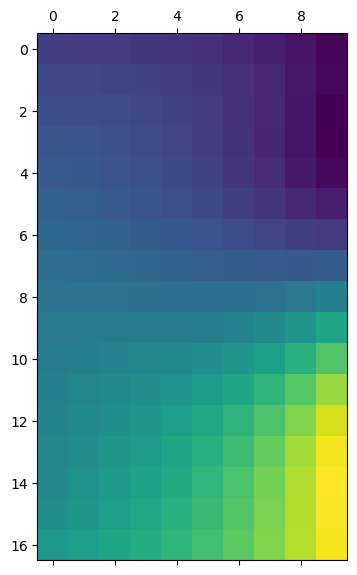

In [8]:
fitted_surf = np.polynomial.polynomial.polygrid2d(x, y, coeff.reshape((6, 6)))
print(fitted_surf.shape)
plt.matshow(fitted_surf)

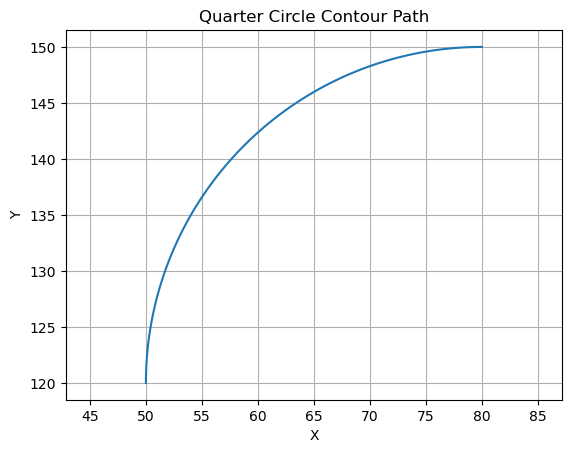

In [9]:
# Define start and end points
x_fic_start = 50
x_fic_end = 80
y_fic_start = 120
y_fic_end = 150

# Calculate center of the circle
center_x = x_fic_end
center_y = y_fic_start

# Calculate radius of the circle
radius = x_fic_end - x_fic_start

# Generate circle path
theta = np.linspace(np.pi, np.pi/2, 100)
circle_x = center_x + radius * np.cos(theta)
circle_y = center_y + radius * np.sin(theta)

# Plot circle
plt.plot(circle_x, circle_y)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Quarter Circle Contour Path')
plt.grid(True)
plt.axis('equal')
plt.show()

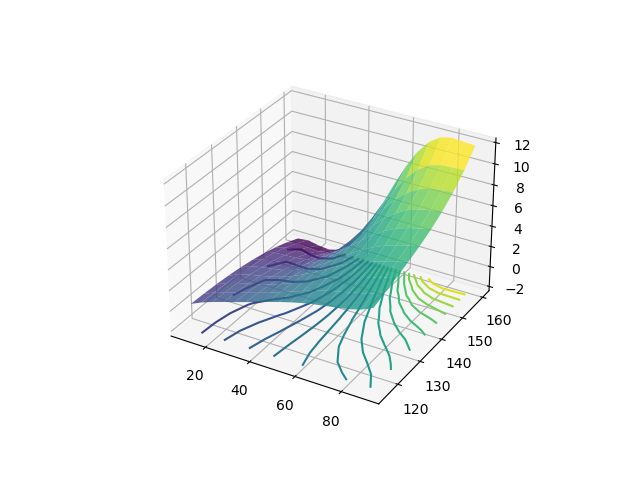

In [32]:
%matplotlib widget

X, Y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

# Plot surface
surf = ax.plot_surface(X, Y, fitted_surf.T, cmap="viridis", alpha=0.8)

# Plot contour lines on the surface
num_levels = 20
contour_levels = np.linspace(np.min(fitted_surf), np.max(fitted_surf), num_levels)
contour_surf = ax.contour(X, Y, fitted_surf.T, levels=contour_levels, offset=np.min(fitted_surf), cmap='viridis')

plt.show()

In [11]:
def h_contact(x):
    return np.polynomial.polynomial.polygrid2d(x[0], x[1], coeff.reshape((6, 6)))

In [12]:
# Test : Single Point
x_1 = np.array([63, 132, 0])
x_2 = np.array([90, 126, 0])
print(h_contact(x_1), h_contact(x_2))

4.771520729535594 6.371267217877853


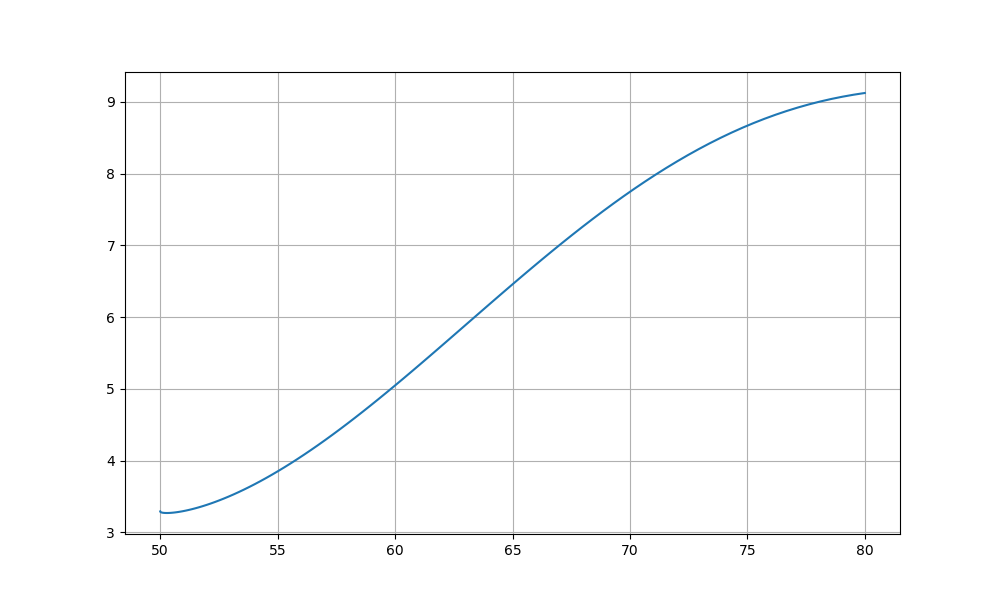

In [13]:
# Test : A quarter circle path
z_fic = np.polynomial.polynomial.polyval2d(circle_x[:], circle_y[:], coeff.reshape((6, 6)))

plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(circle_x[:], z_fic[:])

In [14]:
# Measurement Noise
R = np.array([[rms**2]])

# 3 -  Data Preprocess

In [15]:
# Data format : 
#           timestamp，
#           magnetic_x, magnetic_y, magnetic_z, 
#           lv_x, lv_y, lv_z, av_x, av_y. av_z

trajectory_df = pd.read_csv("data/D_Cir_6_1/trajectory.csv")

In [16]:
# delta time : second s

from datetime import datetime

dt_frame = np.array(trajectory_df)[:, 0]

dt = [0]
for i in range(1, dt_frame.shape[0]):
    tr = datetime.fromtimestamp(dt_frame[i])
    tf = datetime.fromtimestamp(dt_frame[i-1])
    dt.append((tr-tf).total_seconds())
dt = np.array(dt)

In [17]:
# linear- and angular-veolocity : mm/s & rad/s 

# be careful of coordinate frame translation !!!
linear_vel = np.array([np.array(trajectory_df)[:, 5], -np.array(trajectory_df)[:, 6], np.array(trajectory_df)[:, 4]]) * 1e3
angular_vel = np.array([np.array(trajectory_df)[:, 7], np.array(trajectory_df)[:, 8], np.array(trajectory_df)[:, 9]])

us = np.append(linear_vel, angular_vel, axis=0).T

In [18]:
# Measurements Update : magnetic_y
zs = [np.array([np.array(trajectory_df)[i, 2]]) for i in range(trajectory_df.shape[0])]

# 4 - UKF with Fading Memory

In [19]:
# Initial estimate

x_initial = np.array([85, 125, 0])

In [20]:
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints

sigmas = MerweScaledSigmaPoints(3, alpha=.1, beta=2., kappa=0.)
ukf = UKF(dim_x=3, dim_z=1, fx=f_contact,
          hx=h_contact, dt=None, points=sigmas)

ukf.x = x_initial
ukf.R = R
ukf.Q = Q

# Introduce adaptive fading memory filter to compensate the error from dynamic contact 
ukf.alpha = 1.008

In [21]:
ukf

UnscentedKalmanFilter object
x = [ 85 125   0]
P = [[1. 0. 0.]
     [0. 1. 0.]
     [0. 0. 1.]]
x_prior = [0. 0. 0.]
P_prior = [[1. 0. 0.]
           [0. 1. 0.]
           [0. 0. 1.]]
Q = [[1.e-01 0.e+00 0.e+00]
     [0.e+00 1.e-01 0.e+00]
     [0.e+00 0.e+00 1.e-05]]
R = [[0.03764077]]
S = [[0.]]
K = [[0. 0. 0.]].T
y = [0.]
log-likelihood = -708.3964185322641
likelihood = 2.2250738585072014e-308
mahalanobis = 0.0
sigmas_f = [[0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]]
h = [[0. 0. 0. 0. 0. 0. 0.]].T
Wm = [-99.          16.66666667  16.66666667  16.66666667  16.66666667
       16.66666667  16.66666667]
Wc = [-96.01        16.66666667  16.66666667  16.66666667  16.66666667
       16.66666667  16.66666667]
residual_x = <ufunc 'subtract'>
residual_z = <ufunc 'subtract'>
msqrt = <function cholesky at 0x000002EDF55948B0>
hx = <function h_contact at 0x000002EDF713A160>
fx = <function f_co

# 5 - Test

In [22]:
uxs = []
for _ in range(len(zs)):
    ukf.predict(u=us[_], dt=dt[_])
    ukf.update(zs[_])
    uxs.append(ukf.x.copy())
uxs = np.array(uxs)

In [23]:
uxs.shape

(1129, 3)

In [24]:
from kf_book.book_plots import IntSlider

print(uxs)

def interactive_estimatesonbase(iter):

    global fig
    if fig is not None: plt.close(fig)
    fig = plt.figure(figsize=(10, 6))

    plt.grid()
    plt.ylim([115, 160])
    plt.xlim([0, 100])
    plt.plot(uxs[:iter, 0], uxs[:iter, 1], label='Estimated Trajectory')
    plt.scatter(uxs[iter-1, 0], uxs[iter-1, 1], marker='o', c='#d62728')
    plt.show()

interact(interactive_estimatesonbase, iter=IntSlider(value=1, min=0, max=uxs.shape[0]))

[[8.56504959e+01 1.25886839e+02 1.87804986e-16]
 [8.60863877e+01 1.26461445e+02 2.68983609e-16]
 [8.71538053e+01 1.26970741e+02 4.89931771e-16]
 ...
 [7.58405138e+01 1.33023748e+02 2.77873010e-14]
 [7.55894781e+01 1.33115046e+02 4.30244449e-14]
 [7.54499670e+01 1.33033442e+02 5.47725626e-14]]


interactive(children=(IntSlider(value=1, continuous_update=False, description='iter', max=1129), Output()), _d…

<function __main__.interactive_estimatesonbase(iter)>

No such comm: 6d434f48472448289ad4ebbc7bef8d94


No such comm: 01673827897044729eaa0933d2bb24a6


No such comm: 7ca4929f77c64e1089a86d07491616b2


No such comm: d7c26e248f2748acbb4d91c601ebbcc8


No such comm: 03f8555e560c449e9b77431de876587d


No such comm: d9815930067548408237b90a224f87f0


No such comm: ee3931219d774c15aa0e5eb409388d0a


No such comm: 9341c0f9920b441aae3047dadfd1fb20


No such comm: 9f78dcd1a4fb4e3eb79d8e346c9d8462


No such comm: 42e3b20925024fc1a657ab23ec59a067


No such comm: dec65b8d819a47edb2a15b6e1d7357bd


No such comm: d1ea6ad2c56a473c92cfd59dde63fdfd


No such comm: 1aa6f10e39144af9954b7700aed10d77


No such comm: 078b1491a16f4f0296beffcbb12d9a18


No such comm: 9efa91772700424d95139f9d3f8cd777


No such comm: 22920f87bf684115a267e885f04a770e


No such comm: 65e939154fd1493b84b09516a4f4a50c


No such comm: 0699c8c50ddf461c9a304b3bf41570b7


No such comm: 655060d022b24c589b368dfeec4519af


No such comm: 157532b13a18473293ccd688671ee959


No such comm: bf04ed5f624644eeb167d79f0f6a680f


No such comm: 2430090b071e4d6f990b1e2c4658063e


No such comm: f1283cda9d0847f88792a33c6f6ecf01


No such comm: d987f4e17c9146d08206e85f31b15d36


No such comm: 1024372de257444f9a12c4d267a489af


No such comm: 42b7de6f9a454580897a0773a65794e9


No such comm: 5a257a9fa995434096ef7c1d781158c3


No such comm: bef907a4581b4386aa4187a79261a08c


No such comm: 80763bc37e3b4005ad103bf478ec55e9


No such comm: df6c676f9fe542fa89865d71d4669ccb


No such comm: 94565b660b9240d0a2cdf9c941c4f41e


No such comm: 3ebbe0b63f174e2cb24d71e4ba2b927a


No such comm: d67432fa81f94ecea964d23a64bb4892


No such comm: 85c940e64f564276817d8e6910e8619d


No such comm: a7209c04fc6f42389db6a197b39c7498


No such comm: 714eed66afa64fbcb4a788f9c289dc98


No such comm: eedf93374d484b3b8cd808f8232433d9


No such comm: d6b6990ad04f482eb30909703def6312


No such comm: f9d6bdb4be6c47908e8b4893d841fde6


No such comm: 11f6561fe9dd4e5fa084461e5c3cc35b


No such comm: c34029c14ec94738bc90d3d5eb00229d


No such comm: a7228295d32d4c4fb1726ea892ba6061


No such comm: c617f916dd3b404b915aeb14d03ab68b


No such comm: fa4b7c57e095425aa48e0af1bee088b9


No such comm: 075f0fec670f41668d536113c4c88a86


No such comm: 1208e09eea80486eb26a837509462ac7


No such comm: 3b7deff915d94a4197ab5b50e451879a


No such comm: e34039e1339d4f3c979d61bb89f2f005


No such comm: f37381642622463daa8dff82c0afd425


No such comm: 5b019bb7476e42dca84aeaabc41428d4


No such comm: 205c1b328ba345d1b8c42d5dda5a5fc6


No such comm: 99f43f78f0ee483a9f5555c6f3d19d7c


No such comm: 57d36c6c988842eab8c3409c14b2f315


No such comm: cad5cb8f8956419798ea4780a13f1283


No such comm: aae041bd5cce4d77b6a777a1a2811f54


No such comm: e4d17f4f0cd04e06a82bdf41a12a425d


No such comm: 384b393637014f3f9d2113d9c364f9ce


No such comm: a8c198cc8a0349d6b436fe83bfd669a6


No such comm: 8c1d03b148cf49bcafd009cdb88664c8


No such comm: b802a752913c466ba6a2be64d4a8d90d


No such comm: a9f0b3ef4f684579b59a06c15db2144e


No such comm: 40dfb2781487454c8f07a37256cf330b


No such comm: ee3ac00ff5c04fd499ace6ac80ff4408


No such comm: f55859550eb1450db6b7f37fc4a20be4


No such comm: 8b4b009223d841549ccbd9b826d81794


No such comm: b02f9dabdf52419abd6c3ca4906c156f


No such comm: 9e490dd9e44541d6b718764480eda984


No such comm: e107587ab629414384fa640da222eab1


No such comm: ef358ee2d95048aa92bd0980f9f4b235


No such comm: a55f9de6eb65443d940a031647012b57


No such comm: d86c2655c19345b6a2a056b4a71bc23a


No such comm: 191284c51d41402faa79482aa2d30497


No such comm: bfa1d647c19c41dbaeea77864eee2eef


No such comm: 55b06e8a899e45faa84a60d6f05f62ca


No such comm: 854f49bd5e1e4bfdb8227945f10e6240


### Dynamic contact results:

In [25]:
# set the first base frame position as the origin of fixed world frame

uxs_ = []
displacement = np.array([0. ,0. ,0.]) # overall position displacement from first iteration

for _ in range(uxs.shape[0]):
    displacement += np.dot(us[_][:3], dt[_])
    temp = uxs[_] + displacement
    uxs_.append(temp)
uxs_ = np.array(uxs_)

In [26]:
uxs_.shape

(1129, 3)

[[8.56504959e+01 1.25886839e+02 1.87804986e-16]
 [8.60890941e+01 1.26461445e+02 2.68983609e-16]
 [8.77990709e+01 1.26970741e+02 4.89931771e-16]
 ...
 [6.98741884e+01 1.33023748e+02 2.77873010e-14]
 [6.89605063e+01 1.33115046e+02 4.30244449e-14]
 [6.88196488e+01 1.33033442e+02 5.47725626e-14]]


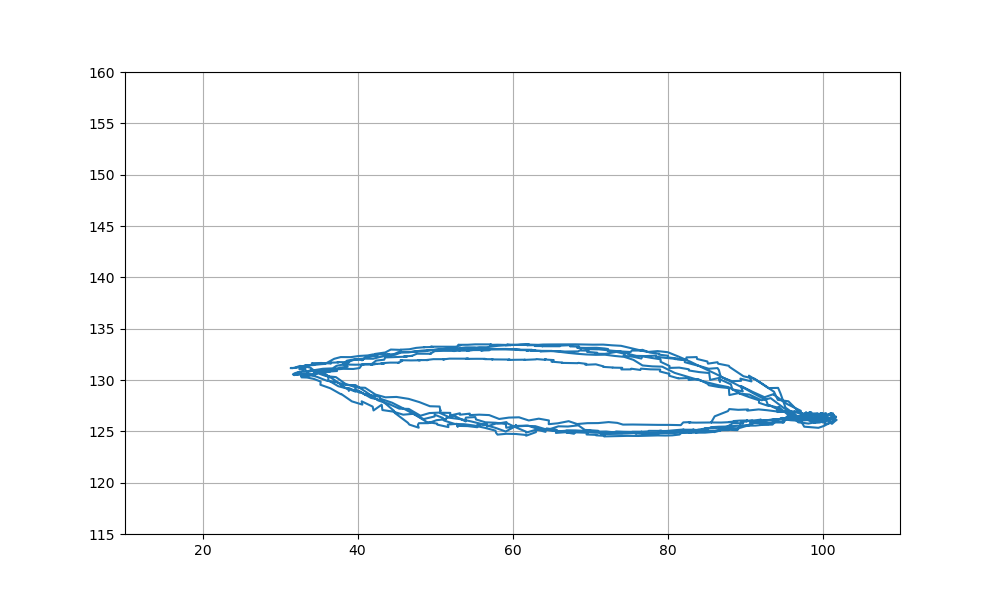

In [27]:
print(uxs_)

plt.figure(figsize=(10, 6))
plt.grid()
plt.ylim([115, 160])
plt.xlim([10, 110])
plt.plot(uxs_[:, 0], uxs_[:, 1], label='Estimated Trajectory')

We shall check how the magnetic flux changed in the certain direction: y 

In [28]:
t = np.array(trajectory_df)[:, 0]
mag_x = np.array(trajectory_df)[:, 1]
mag_y = np.array(trajectory_df)[:, 2]
mag_z = np.array(trajectory_df)[:, 3]

print(np.min(mag_y), np.max(mag_y))

4.679999828338623 6.889999866485596


[1.70902438e+09 1.70902438e+09 1.70902438e+09 ... 1.70902441e+09
 1.70902441e+09 1.70902441e+09]
[6.36999989 6.36999989 6.5        ... 6.10999966 6.23999977 5.97999954]


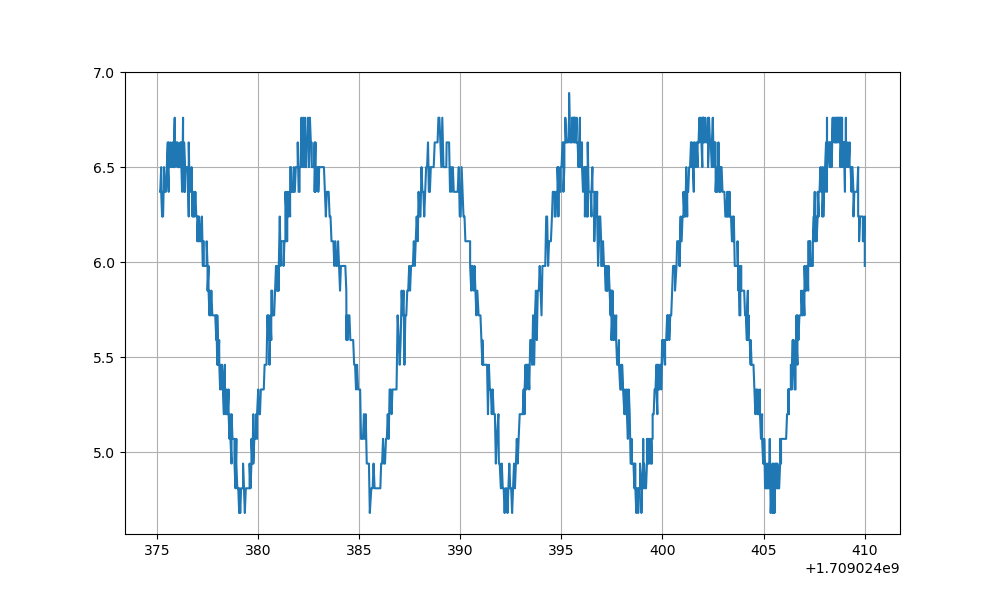

In [29]:
print(t)
print(mag_y)

plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(t[:], mag_y[:], label='Magnetic Flux in Y-axis')

[1.70902438e+09 1.70902438e+09 1.70902438e+09 ... 1.70902441e+09
 1.70902441e+09 1.70902441e+09]
[ -9.61999989  -9.61999989  -9.48999977 ...  -9.61999989 -10.00999928
  -9.75      ]


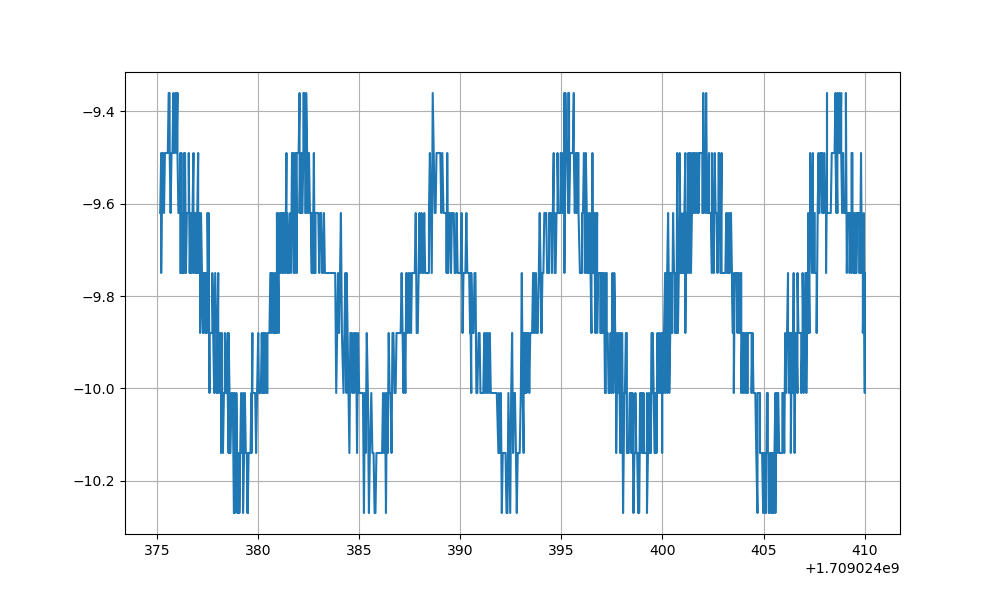

In [30]:
print(t)
print(mag_x)

plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(t[:], mag_x[:], label='Magnetic Flux in Y-axis')

[ -9.61999989  -9.61999989  -9.48999977 ...  -9.61999989 -10.00999928
  -9.75      ]
[6.36999989 6.36999989 6.5        ... 6.10999966 6.23999977 5.97999954]


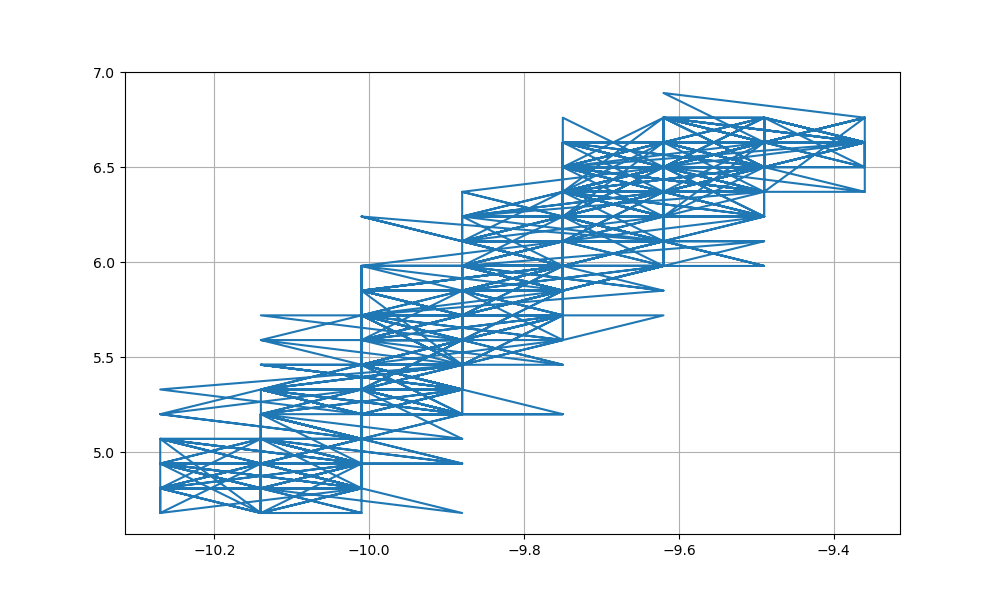

In [31]:
print(mag_x)
print(mag_y)

plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(mag_x[:], mag_y[:], label='Magnetic Flux in Y-axis')